In [ ]:
# ! pip install facenet_pytorch

In [ ]:
import torch
from facenet_pytorch import InceptionResnetV1
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Load LFW (Labeled Faces in the Wild) dataset 
lfw = fetch_lfw_people(min_faces_per_person=5, resize=0.5, color=True)
images = lfw.images  # (n_samples, h, w, 3)
labels = lfw.target
label_names = lfw.target_names

# Your race mapping
race_mapping = {
    "Al Sharpton": "Black",
    "Allyson Felix": "Black",
    "Angela Bassett": "Black",
    "Ashanti": "Black",
    "Chanda Rubin": "Black",
    "Charles Moose": "Black",
    "Condoleezza Rice": "Black",
    "Denzel Washington": "Black",
    "Halle Berry": "Black",
    "James Blake": "Black",
    "Jesse Jackson": "Black",
    "John Allen Muhammad": "Black",
    "LeBron James": "Black",
    "Muhammad Ali": "Black",
    "Russell Simmons": "Black",
    "Serena Williams": "Black",
    "Thabo Mbeki": "Black",
    "Tiger Woods": "Black",
    "Venus Williams": "Black",
    "Adrien Brody": "White",
    "Al Gore": "White",
    "Alan Greenspan": "White",
    "Albert Costa": "White",
    "Amelie Mauresmo": "White",
    "Andy Roddick": "White",
    "Angela Merkel": "White",
    "Angelina Jolie": "White",
    "Anna Kournikova": "White",
    "Ari Fleischer": "White",
    "Arnold Schwarzenegger": "White",
    "Ben Affleck": "White",
    "Bill Clinton": "White",
    "Bill Gates": "White",
    "Britney Spears": "White",
    "Cameron Diaz": "White",
    "Catherine Zeta-Jones": "White",
    "Charlton Heston": "White",
    "Colin Farrell": "White"
}

# Create name -> indices mapping
name_to_indices = defaultdict(list)
for idx, label_idx in enumerate(labels):
    name = label_names[label_idx]
    name_to_indices[name].append(idx)

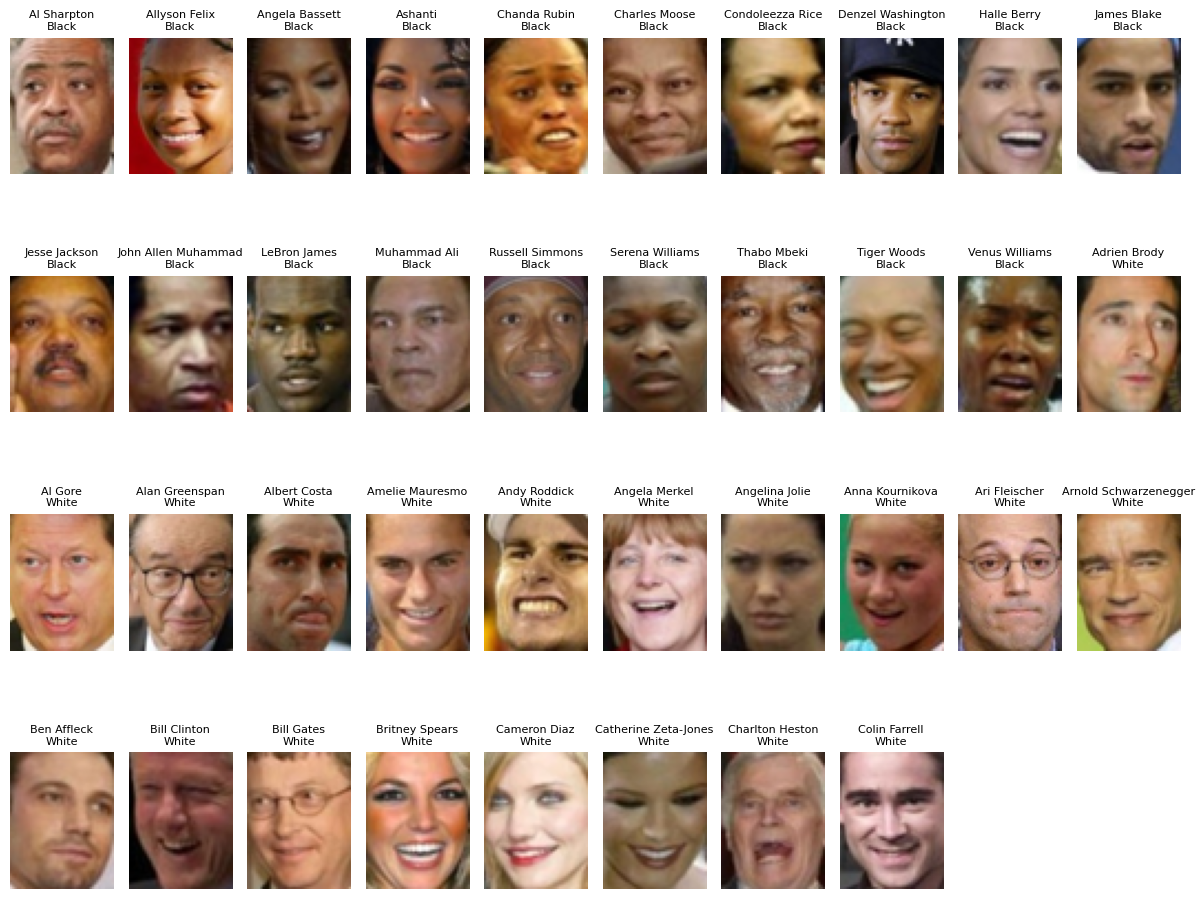

In [6]:
# Display example images
matched_names = [name for name in race_mapping]

plt.figure(figsize=(12, 10))
for j, name in enumerate(matched_names):
    idx = name_to_indices[name][0]  # Show the first image
    plt.subplot(4, 10, j + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"{name}\n{race_mapping[name]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit


# Filter indices for people in race_mapping only
selected_indices = []
selected_names = []
for name in race_mapping.keys():
    if name in name_to_indices:
        selected_indices.extend(name_to_indices[name])
        selected_names.append(name)

X = images[selected_indices]  # filtered images
y_names = [label_names[labels[i]] for i in selected_indices]

# Encode string labels to integers
le = LabelEncoder()
y = le.fit_transform(y_names)

# Load pretrained Facenet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Preprocess and extract embeddings
def preprocess(img):
    # facenet expects (3,160,160) float tensors normalized in [-1,1]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    return transform(img)

embeddings = []
with torch.no_grad():
    for img in X:
        img_t = preprocess(img).to(device)
        emb = model(img_t.unsqueeze(0))  # batch size 1
        embeddings.append(emb.cpu().numpy()[0])

X_embedded = np.array(embeddings)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_embedded, y):
    X_train, X_test = X_embedded[train_idx], X_embedded[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print(f'Trainset size: {X_train.shape[0]}')
print(f'Testset size: {X_test.shape[0]}')

# SVM classifier with scaling pipeline
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Trainset size: 385
Testset size: 97
Classification Report:

                       precision    recall  f1-score   support

         Adrien Brody       1.00      1.00      1.00         2
              Al Gore       1.00      1.00      1.00         2
          Al Sharpton       1.00      1.00      1.00         1
       Alan Greenspan       1.00      1.00      1.00         1
         Albert Costa       1.00      1.00      1.00         1
        Allyson Felix       1.00      1.00      1.00         1
      Amelie Mauresmo       1.00      1.00      1.00         4
         Andy Roddick       1.00      1.00      1.00         3
       Angela Bassett       1.00      1.00      1.00         1
        Angela Merkel       1.00      1.00      1.00         1
       Angelina Jolie       1.00      1.00      1.00         4
      Anna Kournikova       1.00      1.00      1.00         2
        Ari Fleischer       1.00      1.00      1.00         3
Arnold Schwarzenegger       1.00      1.00      1.00     

In [8]:
from sklearn.metrics import classification_report

def evaluate_per_race(y_true_encoded, y_pred_encoded, label_encoder, race_mapping):
    # Decode encoded labels back to string names
    y_true_names = label_encoder.inverse_transform(y_true_encoded)
    y_pred_names = label_encoder.inverse_transform(y_pred_encoded)

    # Map names to races
    def get_race(name):
        return race_mapping.get(name, "Unknown")

    races_true = [get_race(name) for name in y_true_names]

    # Evaluate per race
    for race in sorted(set(races_true)):
        idxs = [i for i, r in enumerate(races_true) if r == race]
        y_true_race = [y_true_names[i] for i in idxs]
        y_pred_race = [y_pred_names[i] for i in idxs]

        print(f"\nClassification report for race: {race}")
        print(classification_report(y_true_race, y_pred_race, zero_division=0))

In [9]:
evaluate_per_race(y_test, y_pred, le, race_mapping)


Classification report for race: Black
                     precision    recall  f1-score   support

        Al Sharpton       1.00      1.00      1.00         1
      Allyson Felix       1.00      1.00      1.00         1
     Angela Bassett       1.00      1.00      1.00         1
            Ashanti       1.00      1.00      1.00         1
       Chanda Rubin       1.00      1.00      1.00         1
      Charles Moose       1.00      1.00      1.00         3
   Condoleezza Rice       1.00      1.00      1.00         2
  Denzel Washington       1.00      1.00      1.00         1
        Halle Berry       1.00      1.00      1.00         3
        James Blake       1.00      1.00      1.00         3
      Jesse Jackson       1.00      1.00      1.00         2
John Allen Muhammad       1.00      1.00      1.00         2
       LeBron James       1.00      1.00      1.00         1
       Muhammad Ali       1.00      1.00      1.00         2
    Russell Simmons       1.00      1.00     

In [10]:
import matplotlib.pyplot as plt

def plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred, race_mapping, images):
  # Number of samples to display
  num_samples = 10
  indices = np.random.choice(len(X_test), size=num_samples, replace=False)

  plt.figure(figsize=(15, 5))
  for i, idx in enumerate(indices):
      # Get original image index for display
      embedded_idx = np.where((X_embedded == X_test[idx]).all(axis=1))[0][0]
      orig_idx = selected_indices[embedded_idx]

      true_name = le.inverse_transform([y_test[idx]])[0]
      pred_name = le.inverse_transform([y_pred[idx]])[0]
      title_color = 'green' if true_name == pred_name else 'red'
      race = race_mapping.get(true_name, "Unknown")

      plt.subplot(2, num_samples // 2, i + 1)
      plt.imshow(images[orig_idx])
      plt.axis('off')


      plt.title(f"{race}\nTrue: {true_name}\nPred: {pred_name}", color=title_color, fontsize=10)

  plt.tight_layout()
  plt.show()


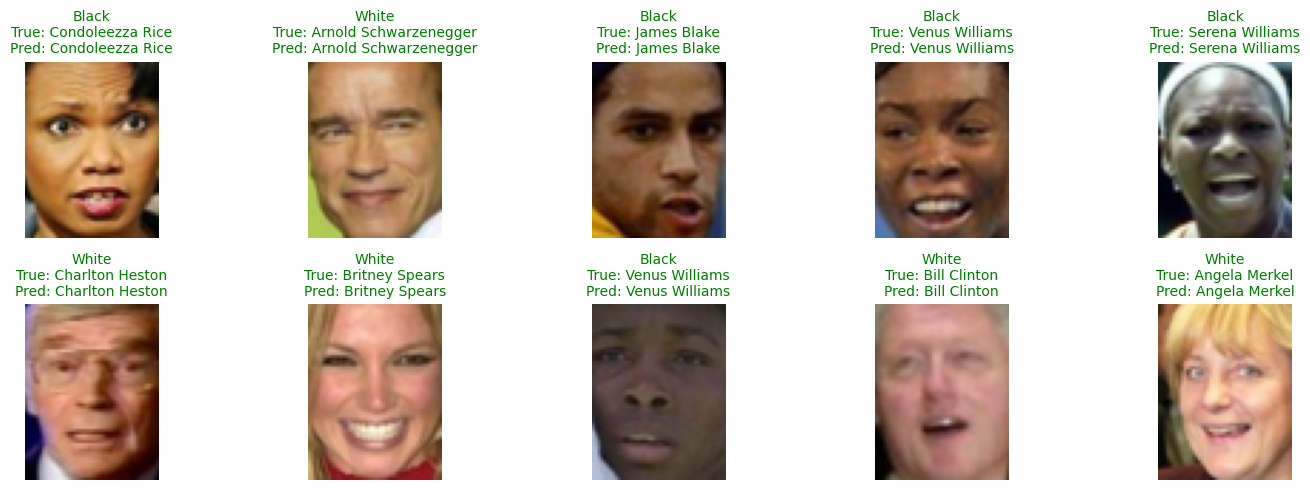

In [11]:
plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred, race_mapping, images)

Adverserial

In [12]:
import torch
import numpy as np
from sklearn.metrics import classification_report
from collections import defaultdict
from tqdm import tqdm

# PGD attack function: multiple small FGSM steps with projection
def invisible_cloak(image, epsilon, alpha, iters, model):
    ori_image = image.clone().detach()
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    for _ in range(iters):
        output = model(perturbed_image)
        loss = output.norm()  # maximize embedding norm
        model.zero_grad()
        if perturbed_image.grad is not None:
            perturbed_image.grad.data.zero_()
        loss.backward()
        data_grad = perturbed_image.grad.data

        perturbed_image = perturbed_image + alpha * data_grad.sign()
        # Project back into epsilon ball and clip to [-1,1]
        eta = torch.clamp(perturbed_image - ori_image, min=-epsilon, max=epsilon)
        perturbed_image = torch.clamp(ori_image + eta, -1, 1).detach()
        perturbed_image.requires_grad = True

    return perturbed_image.detach()

model.eval()
model.requires_grad_(False)

X_train_cloaked = []
y_train_cloaked = []
perturbed_images_dict = {}  # Save perturbed images indexed by i in train set

print("Perturbing white training images with PGD...")
for i, emb in tqdm(enumerate(X_train), total=len(X_train)):
    idx_in_all = np.where((X_embedded == X_train[i]).all(axis=1))[0][0]
    name = y_names[idx_in_all]
    race = race_mapping.get(name, "Unknown")

    if race == "White":
        # Cloak white training image (for toy worldbuilding case-study)
        img = X[idx_in_all]
        img_t = preprocess(img).unsqueeze(0).to(device)

        perturbed_img = invisible_cloak(img_t, epsilon=0.3, alpha=0.05, iters=30, model=model)

        with torch.no_grad():
            emb_cloaked = model(perturbed_img).cpu().numpy()[0]

        X_train_cloaked.append(emb_cloaked)
        y_train_cloaked.append(y_train[i])
        perturbed_images_dict[i] = perturbed_img.squeeze(0).cpu()  # save tensor for visualization
    else:
        X_train_cloaked.append(X_train[i])
        y_train_cloaked.append(y_train[i])

X_train_cloaked = np.array(X_train_cloaked)

Perturbing white training images with PGD...


100%|██████████| 385/385 [28:56<00:00,  4.51s/it]


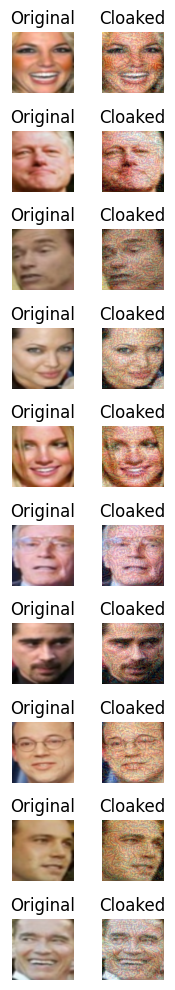

In [13]:
import matplotlib.pyplot as plt

def imshow(img_tensor, title=""):
    # img_tensor expected in [-1,1], shape (3,160,160)
    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    img = (img * 0.5) + 0.5  # unnormalize to [0,1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

num_show = 10
shown = 0

plt.figure(figsize=(2, num_show))

for i in range(len(X_train_cloaked)):
    if i in perturbed_images_dict and shown < num_show:
        idx_in_all = np.where((X_embedded == X_train[i]).all(axis=1))[0][0]
        name = y_names[idx_in_all]

        original_img = preprocess(X[idx_in_all]).squeeze(0)
        perturbed_img = perturbed_images_dict[i]

        plt.subplot(num_show, 2, 2*shown + 1)
        imshow(original_img, title=f"Original")

        plt.subplot(num_show, 2, 2*shown + 2)
        imshow(perturbed_img, title=f"Cloaked")

        shown += 1

plt.tight_layout()
plt.show()

In [14]:
# Train SVM classifier on cloaked training set
clf_cloaked = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf_cloaked.fit(X_train_cloaked, y_train_cloaked)

# Predict and evaluate on original test set
y_pred_cloaked = clf_cloaked.predict(X_test)

In [16]:
# Evaluate results by Race
evaluate_per_race(y_test, y_pred_cloaked, le, race_mapping)


Classification report for race: Black
                     precision    recall  f1-score   support

        Al Sharpton       1.00      1.00      1.00         1
      Allyson Felix       1.00      1.00      1.00         1
     Angela Bassett       1.00      1.00      1.00         1
            Ashanti       1.00      1.00      1.00         1
       Chanda Rubin       1.00      1.00      1.00         1
      Charles Moose       1.00      1.00      1.00         3
   Condoleezza Rice       1.00      1.00      1.00         2
  Denzel Washington       1.00      1.00      1.00         1
        Halle Berry       1.00      1.00      1.00         3
        James Blake       1.00      1.00      1.00         3
      Jesse Jackson       1.00      1.00      1.00         2
John Allen Muhammad       1.00      1.00      1.00         2
       LeBron James       1.00      1.00      1.00         1
       Muhammad Ali       1.00      1.00      1.00         2
    Russell Simmons       1.00      1.00     

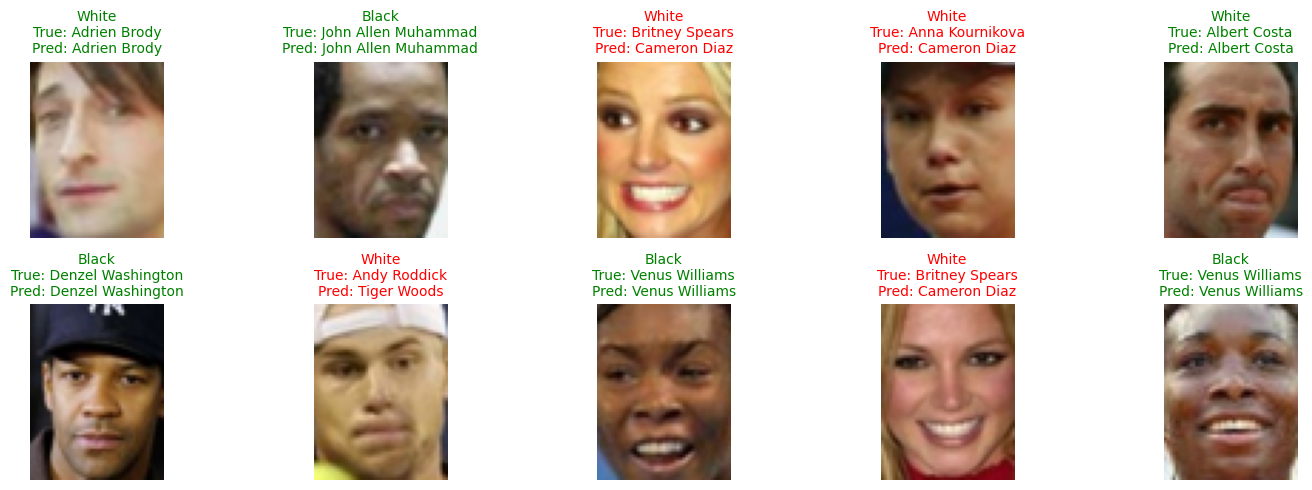

In [19]:
plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred_cloaked, race_mapping, images)

In [20]:
import pandas as pd

records_before = []
records_after = []

for i in range(len(y_test)):
    try:
        orig_idx = selected_indices[test_idx[i]]  # index into full images array
        name = y_names[test_idx[i]]               # name associated with test image
        race = race_mapping.get(name, "Unknown")
        img = images[orig_idx]
        true_label = le.inverse_transform([y_test[i]])[0]
        pred_label_before = le.inverse_transform([y_pred[i]])[0]
        pred_label_after = le.inverse_transform([y_pred_cloaked[i]])[0]

        records_before.append({
            'name': name,
            'race': race,
            'image': img,
            'true_label': true_label,
            'pred_label': pred_label_before
        })

        records_after.append({
            'name': name,
            'race': race,
            'image': img,
            'true_label': true_label,
            'pred_label': pred_label_after
        })

    except IndexError as e:
        print(f"[!] Skipped index {i} due to: {e}")
        continue

df_before = pd.DataFrame(records_before)
df_after = pd.DataFrame(records_after)


In [ ]:
df_before['correct'] = df_before['true_label'] == df_before['pred_label']
df_after['correct'] = df_after['true_label'] == df_after['pred_label']

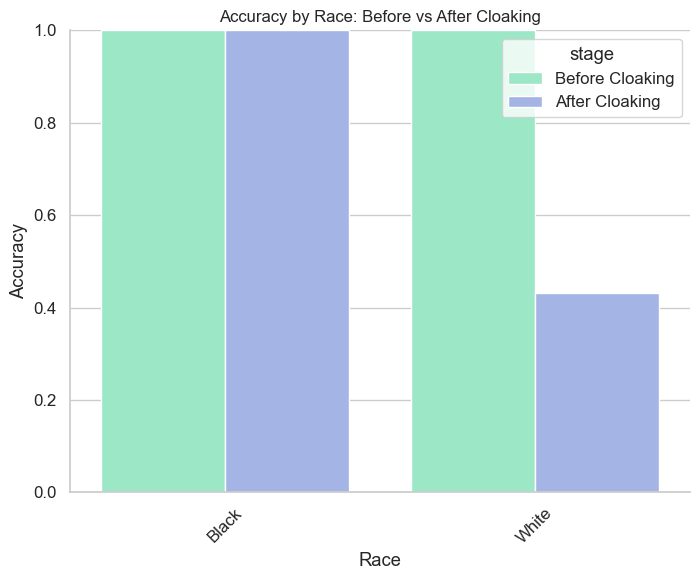

In [49]:
import seaborn as sns


# Compute accuracy per race
acc_before = df_before.groupby('race')['correct'].mean().reset_index(name='accuracy')
acc_before['stage'] = 'Before Cloaking'

acc_after = df_after.groupby('race')['correct'].mean().reset_index(name='accuracy')
acc_after['stage'] = 'After Cloaking'

# Combine into one DataFrame
df_acc = pd.concat([acc_before, acc_after], ignore_index=True)

# Set up the plot
sns.set(style='whitegrid', font_scale=1.1)


custom_palette = {
    "Before Cloaking": "#8EF4C8",  # steel blue
    "After Cloaking": "#99AEF0"   # light sky blue
}


plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_acc, x='race', y='accuracy', hue='stage', palette=custom_palette)

# Beautify
ax.set_title('Accuracy by Race: Before vs After Cloaking', fontsize=12)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Race')
plt.ylim(0, 1)
plt.xticks(rotation=45)
sns.despine()